In [167]:
import warnings
warnings.filterwarnings("ignore")

In [166]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('white')

In [2]:
from ipyparallel import Client
rc = Client(profile='mpi3')
dc = rc[:]

/usr/local/lib/python3.5/dist-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@songthrush')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [ ]:
import os
dc.push({'cwd':os.getcwd()})

In [ ]:
%%px
import os
os.chdir(cwd)

In [ ]:
%%px
import dill
import itertools
import numpy as np
from pauli_channel_approximation import compute_dpn_and_fid
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
%%px 
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [ ]:
%%px
"""
These pkl files contain PCA objects that define the Hamiltonian, 
the controls that were generated, the standard deviation of the controls
used in the robust optimization, etc
"""

pca228 = dill.load(open("pickled_controls228.pkl", 'rb')) # SQRTY 
pca245 = dill.load(open("pickled_controls245.pkl", 'rb')) # SQRTX
pca261 = dill.load(open("pickled_controls261.pkl", 'rb')) # SQRT(ZZ)

These objects have the following attributes:

 'ambient_hamiltonian' - the uncontrolled hamiltonians

'control_hamiltonians' - the controlled hamiltonians

'controlset' - the set of controls generated by grape, indexed i, j with i being the time slice, and j being the control hamiltonian that that amplitude is for.

'detunings' - the detunings (stds) for each control, gaussian distributed with 0 mean. 

'dt' the length of a timestep

'num_controls' the number of controls (should equal the length of controlset)

'probs' the probabilities that come out of the routine

'start' when the algorithm started running

'stop' when the algorithm stopped running

'target_operator' the unitary we're trying to make

'time' the total time the algorithm took

In [ ]:
%%px
pca = pca245

# Diamond Norm

In [ ]:
%%px --target 0
sigI = np.array([[1.,0],[0, 1]], dtype='complex')
sigX = np.array([[0, 1],[1, 0]], dtype='complex')
sigY = np.array([[0,-1],[1, 0]], dtype='complex') * 1.j
sigZ = np.array([[1, 0],[0,-1]], dtype='complex')
sigM = (sigX - 1.j*sigY)/2.
sigP = (sigX + 1.j*sigY)/2.
diamond_distance(sigX,sigY)

In [ ]:
%%px
from pauli_channel_approximation import control_unitaries, error_unitary, off_diagonal_projection, adjoint
import sys
import itertools
from itertools import product
from copy import deepcopy
from functools import reduce

from diamond import diamond_norm, jamiolkowski

def superoperator(unitary):

    return np.kron(unitary.conj(), unitary)

def choi_form(unitary):

    return jamiolkowski(superoperator(unitary))

def diamond_distance(unitary_a,unitary_b):
    return diamond_norm(choi_form(unitary_a) - choi_form(unitary_b))/2.

def compute_diamond_norm(data):
    controlset, ambient_hamiltonian0, combo, dt, control_hamiltonians, target_operator, probs = data
#     print("DOING COMBO {}".format(combo))
#     sys.stdout.flush()
    fidelities = []
    projs = []
    sops = []
    controlset_unitaries = []
    d_norms = []
    #
    #
    # for i, com in enumerate(combo):
    #     if i != 0 and com != 0:
    #         return 0
    for cind, controls in enumerate(controlset):
        newcontrols = deepcopy(controls)
        ambient_hamiltonian = [deepcopy(ah).astype("float") for ah in ambient_hamiltonian0]
        for cnum, value in enumerate(combo):
            cnum -= len(ambient_hamiltonian0)
            if cnum >= 0:
                newcontrols[:, cnum] = newcontrols[:, cnum] * (1 + value)
            if cnum < 0:
                ambient_hamiltonian[cnum] *= float(value)
        step_unitaries = control_unitaries(ambient_hamiltonian,
                                           control_hamiltonians, newcontrols,
                                           dt)
        unitary = reduce(lambda a, b: a.dot(b), step_unitaries)
        sop = error_unitary(unitary, target_operator)
        sops.append(sop)
        ddist = diamond_distance(sop, np.eye(sop.shape[0]))
        with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format(cind,combo,ddist))
        d_norms.append(ddist)
    avg_sop = reduce(lambda a, b: a + b, [prob * sops[i] for i, prob in enumerate(probs)])
    ddist = diamond_distance(avg_sop, np.eye(avg_sop.shape[0]))
    with open('./data/{}.out'.format(rank), 'a+') as f:
            f.write("{}\t{}\t{}\n".format("avg",combo,ddist))
    d_norms.append(ddist)

    return d_norms

def generate_indices(num_points, order_desired):
    num_indices = len(order_desired)
    tuples = product(range(num_points), repeat=num_indices)
    indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] 
                    for i in range(num_indices)]) for t in tuples]
    return indices

In [ ]:
%%px
base = np.logspace(-4.7, np.log(pca.detunings[0][0])/np.log(10), 20)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations0 = [[det,0] for det in controls]

base = np.logspace(-4.7, np.log(pca.detunings[1][0])/np.log(10), 20)
controls = np.concatenate([np.sort(-base),np.array([0]), base])
combinations1 = [[0,det] for det in controls]

try:
    combo = combinations0[rank]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms0 = compute_diamond_norm(lst)
    
    combo = combinations1[rank]
    lst = [pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs]
    d_norms1 = compute_diamond_norm(lst)
except IndexError:
    pass

In [ ]:
diamond_norms = np.array([rc[i]['d_norms'] for i in range(20)])
controls = np.array([rc[i]['combo'][0] for i in range(20)])

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogy(controls, diamond_norms[:,:-1], linewidth = 2, alpha=.6, color='#a6bddb');
plt.semilogy(controls,diamond_norms[:,-1], linewidth = 3, alpha=1, color='#2b8cbe');

In [ ]:
sum(pca.probs)

In [ ]:
plt.plot(rc[0]['d_norms'])

In [ ]:
for i, row in enumerate(d_norms[:-1, :]):
    reordered_row = np.array([row[j] for j in indices])
    plt.plot(range(len(row)), reordered_row)
plt.plot(range(len(d_norms[-1, :])), [d_norms[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
plt.legend()
plt.ylabel("Diamond Distance")
plt.semilogy()
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()


#  Import and plot data

In [3]:
import pandas as pd

# Find available txt files:
import os
filenames = {}
for root, subdirs, files in os.walk(os.getcwd()):
    for fname in files:
        if fname[-3:] == 'out':
            # modify this
            index = int(fname.split('.')[0])
            filenames[index] = os.path.join(root,fname)


In [88]:
def splitlist(c):
    return [float(x) for x in c[1:-1].split(',')]

In [135]:
data = pd.concat([pd.read_csv(f,sep='\t', header=None, names = ['ctrl',1,'diamond']) for f in filenames.values()], ignore_index = True)
data[['xC','yC']] = pd.DataFrame(data[1].apply(splitlist).values.tolist())
data = data.drop(columns=[1])
data.head()

,ctrl,diamond,xC,yC
0,0,0.011201,-0.001,0.0
1,1,0.020129,-0.001,0.0
2,2,0.031446,-0.001,0.0
3,3,0.036725,-0.001,0.0
4,4,0.024513,-0.001,0.0


In [159]:
import seaborn as sns
sns.set_style('white')
sns.despine()

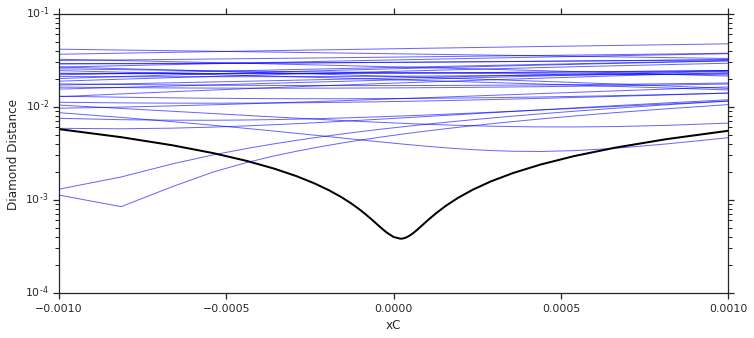

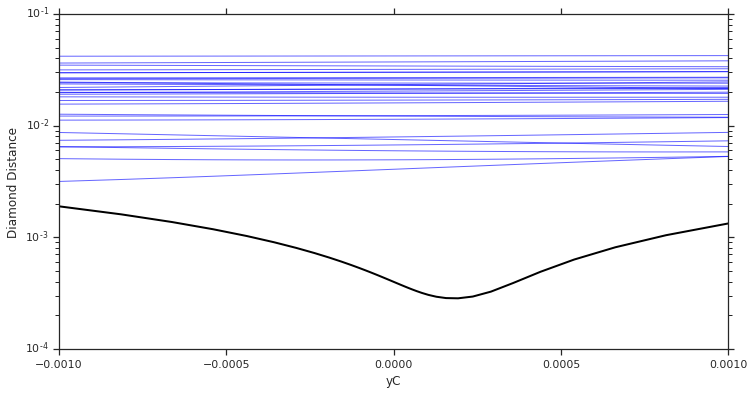

In [169]:
fig, ax = plt.subplots(figsize=(12,5))

data[data['yC']==0][data['ctrl'] !='avg'].groupby('ctrl').plot(x='xC', y='diamond', 
                                                               linewidth=1, ax=ax, alpha=.6,
                                                               legend=False, color = 'blue', 
                                                               logy=True);
data[data['yC']==0][data['ctrl'] =='avg'].groupby('ctrl').plot(x='xC', y='diamond', 
                                                              linewidth=2, ax=ax, legend=False, color = 'black',
                                                              logy=True);
plt.ylabel('Diamond Distance')

fig, ax = plt.subplots(figsize=(12,6))
data[data['xC']==0][data['ctrl'] !='avg'].groupby('ctrl').plot(x='yC', y='diamond', 
                                                               linewidth=1, ax=ax, alpha=.6, legend=False, color = 'blue', 
                                                               logy=True);
data[data['xC']==0][data['ctrl'] =='avg'].groupby('ctrl').plot(x='yC', y='diamond', 
                                                              linewidth=2, ax=ax, legend=False, color = 'black',
                                                              logy=True);
plt.ylabel('Diamond Distance')